# 01 - Import Libraies

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#dl libraraies
import tensorflow as tf
import random as rn

from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#### Setting the Random Seeds

In [2]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)
#keras.utils.set_random_seed(42)

# 02 - Load Dataset

In [3]:
DIR_DAIZY='/kaggle/input/flowers-recognition/flowers/daisy'
DIR_DANDELION='/kaggle/input/flowers-recognition/flowers/dandelion'
DIR_ROSE='/kaggle/input/flowers-recognition/flowers/rose' 
DIR_SUNFLOWER='/kaggle/input/flowers-recognition/flowers/sunflower'
DIR_TULIP='/kaggle/input/flowers-recognition/flowers/tulip'
IMG_SIZE=224
X=[]
Z=[]

In [4]:

def load_data(flower_type,DIR):
  for img in tqdm(os.listdir(DIR)):
    label = flower_type
    path = os.path.join(DIR,img)
    image= load_img(path,target_size=(IMG_SIZE,IMG_SIZE))
    image= img_to_array(image)
    image = preprocess_input(image)

    X.append(image)
    Z.append(str(label))

In [5]:
load_data('daisy',DIR_DAIZY)
print("------------")
print(len(X))

100%|██████████| 764/764 [00:04<00:00, 158.12it/s]

------------
764


In [6]:
load_data('dandelion',DIR_DANDELION)
print("------------")
print(len(X))

100%|██████████| 1052/1052 [00:07<00:00, 146.34it/s]

------------
1816


In [7]:
load_data('rose',DIR_ROSE)
print("------------")
print(len(X))

100%|██████████| 784/784 [00:04<00:00, 164.14it/s]

------------
2600


In [8]:
load_data('sunflower',DIR_SUNFLOWER)
print("------------")
print(len(X))

100%|██████████| 733/733 [00:05<00:00, 142.77it/s]

------------
3333


In [9]:
load_data('tulip',DIR_TULIP)
print("------------")
print(len(X))

100%|██████████| 984/984 [00:06<00:00, 151.22it/s]

------------
4317


In [10]:
len(Z)

4317

# 03 - Preparing the Data


#### Visualizing some Random Images

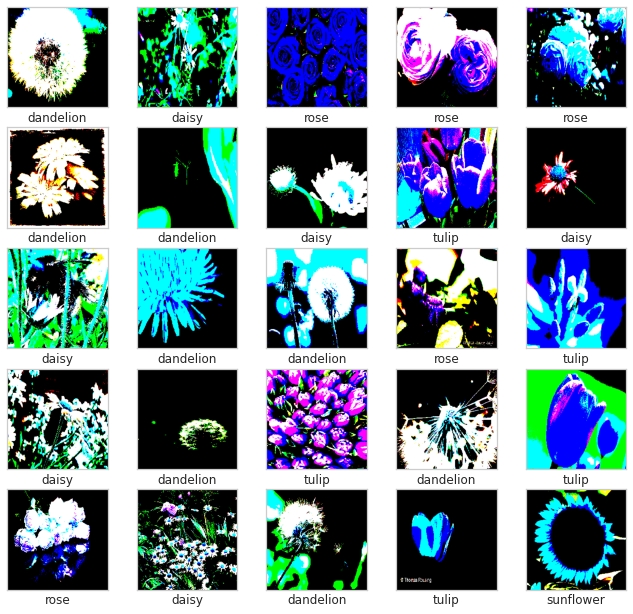

In [11]:
#### Visualizing some Random Images

plt.figure(figsize=(10,10))
#fig,ax = plt.subplots(5,5)

for i in range(25):
  plt.subplot(5,5,1+i)
  l = rn.randint(0,len(Z))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X[l])
  plt.xlabel(Z[l])
plt.show()


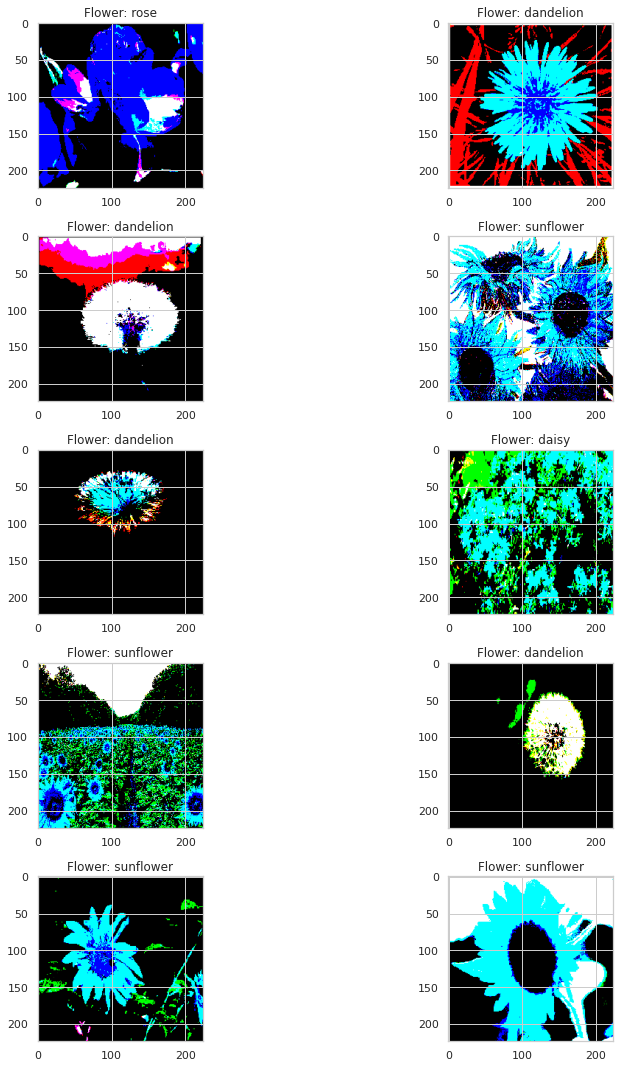

In [12]:

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

In [13]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y,5)
Y[1]

array([1., 0., 0., 0., 0.], dtype=float32)

In [14]:
X = np.array(X)
X=X/255
#X[1]

In [15]:
print(X.shape)
print(Y.shape)

(4317, 224, 224, 3)
(4317, 5)


#### Splitting into Training and Validation Sets

In [16]:
from sklearn.utils import shuffle
X , Y = shuffle(X,Y,random_state=0)

In [17]:
#split data into 75% train , 25% test
(len(X) * 25/100)

1079.25

In [18]:
x_test = X[:1080]
x_train = X[1080:]
y_test = Y[:1080]
y_train =Y[1080:]

In [19]:
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (3237, 224, 224, 3), y_train shape: (3237, 5)
X_test shape: (1080, 224, 224, 3), y_test shape: (1080, 5)


# 04 - Transfer Learning

In [20]:
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=(224,224,3), weights="imagenet")

553476096/553467096 [==============================] - 16s 0us/step


In [21]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
pre_trained_model = keras.Sequential()
for layer in vgg16_model.layers[0:11]:
  layer.trainable=False
  pre_trained_model.add(layer)


#### Pretrained Model

In [23]:
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# 05 - Modeling

In [24]:
pre_trained_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
pre_trained_model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="LeakyReLU"))
pre_trained_model.add(Flatten())
pre_trained_model.add(Dense(units=500,activation="relu"))
pre_trained_model.add(Dense(5,activation='softmax'))
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

#### Compiling the Keras Model & Summary

In [25]:
pre_trained_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

#### Fitting on the Training set and making predcitons on the Validation set

In [26]:
batch_size=128
epochs_2=50
history_2= pre_trained_model.fit(x_train,
                                 y_train,
                                 epochs=epochs_2,
                                 batch_size=batch_size,
                                 validation_data = (x_test,y_test),
                                verbose=1)

Epoch 1/50
26/26 [==============================] - 25s 486ms/step - loss: 1328.8730 - accuracy: 0.2373 - val_loss: 235.5382 - val_accuracy: 0.2574
Epoch 2/50
26/26 [==============================] - 6s 249ms/step - loss: 129.6815 - accuracy: 0.3639 - val_loss: 63.3152 - val_accuracy: 0.4676
Epoch 3/50
26/26 [==============================] - 6s 251ms/step - loss: 61.8745 - accuracy: 0.4436 - val_loss: 60.0543 - val_accuracy: 0.4602
Epoch 4/50
26/26 [==============================] - 7s 256ms/step - loss: 50.7808 - accuracy: 0.4930 - val_loss: 53.3632 - val_accuracy: 0.4639
Epoch 5/50
26/26 [==============================] - 6s 250ms/step - loss: 34.3260 - accuracy: 0.5616 - val_loss: 16.9581 - val_accuracy: 0.6528
Epoch 6/50
26/26 [==============================] - 6s 248ms/step - loss: 14.0323 - accuracy: 0.6812 - val_loss: 11.1270 - val_accuracy: 0.6954
Epoch 7/50
26/26 [==============================] - 6s 251ms/step - loss: 14.8376 - accuracy: 0.6528 - val_loss: 33.1224 - val_accu

In [27]:
pre_trained_model.evaluate(x_test,y_test)

34/34 [==============================] - 5s 98ms/step - loss: 4.4467 - accuracy: 0.7667


[4.446711540222168, 0.7666666507720947]

# 06 - Evaluating the Model Performance


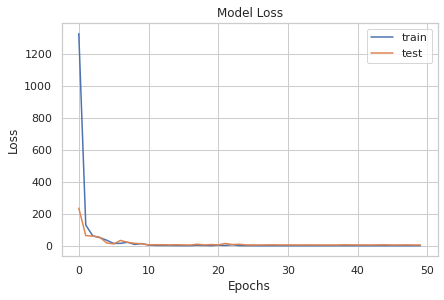

In [28]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

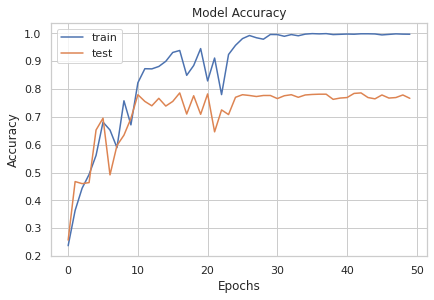

In [29]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [30]:
def calc_pred (model, data):
    prediction = model.predict(data)
    class_predicted= np.argmax(prediction,axis=1)
    return class_predicted

In [31]:
predicted_train = calc_pred(pre_trained_model,x_train)
predicted_test = calc_pred(pre_trained_model,x_test)
predicted_test

array([3, 1, 3, ..., 1, 1, 2])

In [32]:
train_label_np = np.argmax(y_train,axis=1)
train_label_np
test_label_np = np.argmax(y_test,axis=1)
test_label_np

array([3, 1, 1, ..., 1, 2, 2])

In [33]:
labels = []
for l in le.classes_:
  labels.append(l)
labels

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

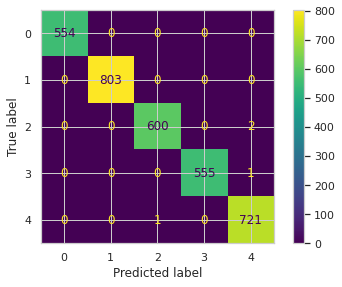

In [34]:
cm_train= confusion_matrix(train_label_np,predicted_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train )

disp.plot()

<AxesSubplot:>

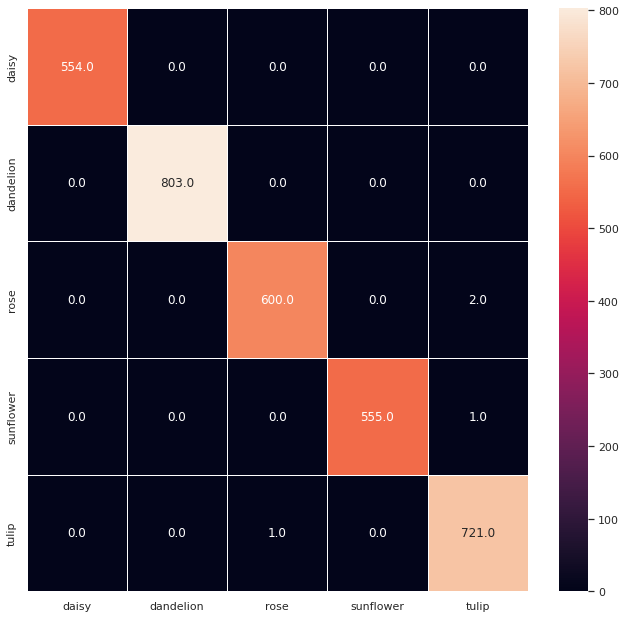

In [35]:
cm_train= confusion_matrix(train_label_np,predicted_train)
plt.figure(figsize=(10,10))
sns.heatmap(cm_train, annot=True, fmt=".1f", linewidth=.5, xticklabels=labels, yticklabels=labels)

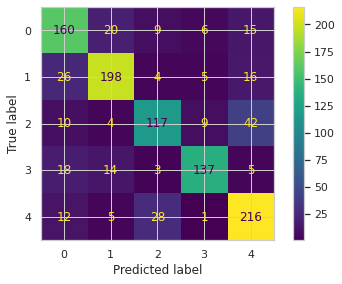

In [36]:
cm_test= confusion_matrix(test_label_np,predicted_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)

disp.plot()

<AxesSubplot:>

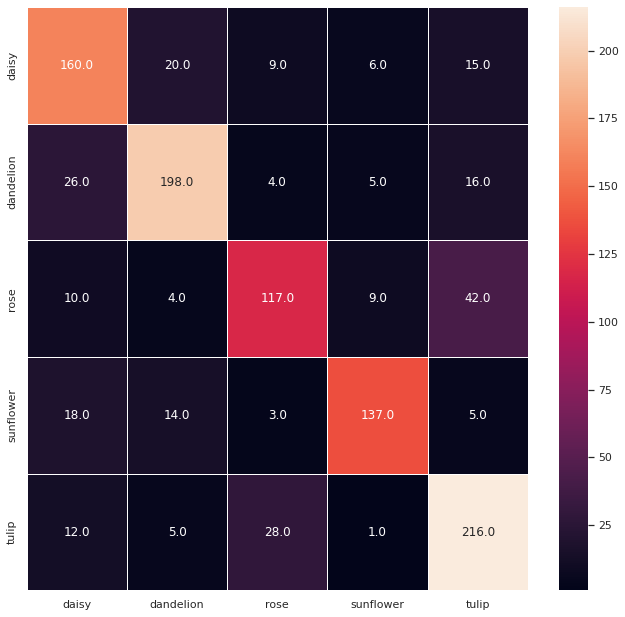

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_test, annot=True, fmt=".1f", linewidth=.5, xticklabels=labels, yticklabels=labels)

In [38]:
print(classification_report(test_label_np, predicted_test, target_names = labels))

              precision    recall  f1-score   support

       daisy       0.71      0.76      0.73       210
   dandelion       0.82      0.80      0.81       249
        rose       0.73      0.64      0.68       182
   sunflower       0.87      0.77      0.82       177
       tulip       0.73      0.82      0.78       262

    accuracy                           0.77      1080
   macro avg       0.77      0.76      0.76      1080
weighted avg       0.77      0.77      0.77      1080



# Thank You